1. Pre-processing: Data cleaning and preparing for modelling

- We will be working on Topic Modelling with BERTopic using the Kaggle news dataset, with news aricles from different mediums in the period 01.10.2023 - 29.11.2023

In [169]:
# libraries
import pandas as pd
import numpy as np
from langdetect import detect

In [170]:
# read csv file
all_news_df = pd.read_csv('/Users/gresasmolica/Downloads/data-5.csv', encoding='utf-8')

In [171]:
# explore data
all_news_df.head()
all_news_df.info()
all_news_df.describe()
all_news_df.columns

# check latest date
all_news_df['published_at'].max()
all_news_df['published_at'].min()

# check unique source_name
all_news_df['source_name'].nunique()

# drop unnecessary columns
all_news_df.drop(['author', 'source_id', 'source_name', 'description', 'content', 'url', 'url_to_image'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105375 entries, 0 to 105374
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   article_id    105375 non-null  int64 
 1   source_id     24495 non-null   object
 2   source_name   105375 non-null  object
 3   author        97156 non-null   object
 4   title         105335 non-null  object
 5   description   104992 non-null  object
 6   url           105375 non-null  object
 7   url_to_image  99751 non-null   object
 8   published_at  105375 non-null  object
 9   content       105375 non-null  object
 10  category      105333 non-null  object
 11  full_content  58432 non-null   object
dtypes: int64(1), object(11)
memory usage: 9.6+ MB


In [172]:
# filter english news content only
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False
    
english_news_df = all_news_df[all_news_df['full_content'].apply(is_english)]

In [173]:
# filter english titles only
english_news_df = english_news_df[english_news_df['title'].apply(is_english)]

In [193]:
# reset the display of rows not to show all the rows
pd.set_option('display.max_rows', 100)

english_news_df['category'].value_counts()


category
Stock          3534
Canada         2175
Health         2013
Real estate    1941
Technology     1919
               ... 
Cabo Verde        3
Honduras          3
Burundi           3
Andorra           3
Martinique        2
Name: count, Length: 255, dtype: int64

In [194]:
# drop null values
english_news_df.dropna()
english_news_df['category'].value_counts()

# print categories that have more 1000 news

print(english_news_df['category'].value_counts()[(english_news_df['category'].value_counts() > 500)])

category
Stock                      3534
Canada                     2175
Health                     2013
Real estate                1941
Technology                 1919
Finance                    1678
News                       1324
COVID                      1313
Education                  1276
India                      1090
Food                       1073
Asia                        934
Jobs                        925
Weather                     917
Australia                   880
Travel                      877
Science                     863
United Kingdom              745
Africa                      739
Cars                        721
America                     676
Climate                     674
Artificial Intelligence     670
Home                        647
Fashion                     623
Facebook                    581
Ukraine                     574
Sports                      568
Mexico                      558
Relationships               557
United States               555

In [204]:
# filter the category to keep: politics, europe, united states, climate, sustainability.

selected_categories = ['Stock', 'Health', 'Technology', 'Food','COVID']

subset_english_news_df = english_news_df[english_news_df['category'].isin(selected_categories)]

subset_english_news_df

,article_id,title,published_at,category,full_content
2585,94368,"LinkedIn hits 1 billion members, adds AI featu...",2023-11-02 03:48:44.000000,Stock,"LinkedIn, the business-focused social network ..."
3071,94410,WeWork to start closing some offices around th...,2023-11-02 00:20:25.000000,Stock,The troubled office-sharing firm WeWork is to ...
3091,94318,Montana GOP Senate candidate would be in the t...,2023-11-02 20:35:30.000000,Stock,"Tim Sheehy, theGOP's anointed candidateto unse..."
3094,94321,The Fed and war in the Middle East are the 2 t...,2023-11-02 16:32:51.000000,Stock,The US is facing two risks that could push the...
3096,94323,The biggest debate in tech,2023-11-02 11:52:11.000000,Stock,Almost Friday!The pics are in from Heidi Klum...
...,...,...,...,...,...
104649,765220,Vow ASA: Extraordinary General Meeting in Vow ...,2023-11-29 13:04:00,Food,"The EGM in Vow has been concluded, and the boa..."
104650,765224,SharkNinja (NYSE:SN) Shares Down 3.7%,2023-11-29 13:06:42,Food,"SharkNinja, Inc. (NYSE:SN–Get Free Report)’s s..."
104651,765225,CAVA Group (NYSE:CAVA) Shares Up 3.3%,2023-11-29 13:04:44,Food,"CAVA Group, Inc. (NYSE:CAVA–Get Free Report)’s..."
104652,765246,Berenberg Bank Cuts Pets at Home Group (LON:PE...,2023-11-29 13:20:45,Food,Pets at Home Group (LON:PETS–Get Free Report)h...


In [216]:
# performing predictions

from sklearn.model_selection import train_test_split
from bertopic import BERTopic
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [217]:
# Split the filtered dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    subset_english_news_df['full_content'],
    subset_english_news_df['category'],
    test_size=0.1,
    random_state=42
)

In [218]:
# Train BERTopic model on the training set
topic_model = BERTopic()
topics_train, _ = topic_model.fit_transform(X_train.tolist())

In [219]:
# Predict topics for the testing set
topics_test, _ = topic_model.transform(X_test.tolist())

# Map topics to categories
category_mapping = {topic: category for topic, category in zip(topics_train, y_train)}

In [220]:
# Assign categories to the test set based on the mapping
predicted_categories = [category_mapping[topic] for topic in topics_test]

In [225]:
print("Classification Report:")
print(classification_report(y_test, predicted_categories))

confusion_matrix = confusion_matrix(y_test, predicted_categories)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.54      0.42      0.47       137
        Food       0.42      0.19      0.26       127
      Health       0.53      0.36      0.43       218
       Stock       0.50      0.85      0.63       339
  Technology       0.49      0.30      0.37       165

    accuracy                           0.51       986
   macro avg       0.50      0.42      0.43       986
weighted avg       0.50      0.51      0.47       986



TypeError: 'numpy.ndarray' object is not callable

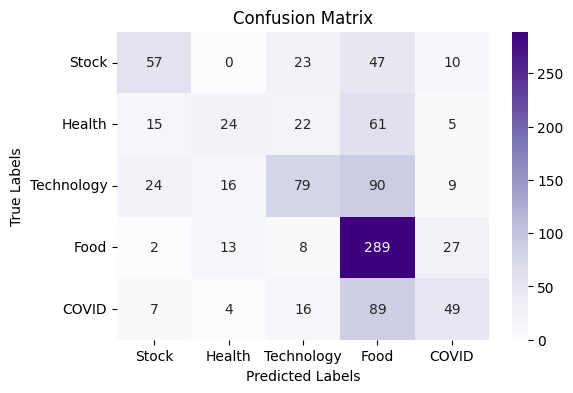

In [226]:
# visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=selected_categories, yticklabels=selected_categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()